# PyTorch 入门与实战 

# 实验2：使用神经网络预测共享单车的使用量

<h2><a id="introduction">一、实验介绍</a></h2>

### 1.1 实验内容

在本次实验中，我们将设计我们的第一个有实用价值的人工神经网络，并用它来预测未来某地区租赁单车的使用情况。

### 1.2 实验知识点

- 数据归一化、类型变量的转换
- 搭建基本神经网络的方法
- 数据分批次训练原则
- 测试及简单分析神经网络的方法

### 1.3 实验环境

- Jupyter Notebook
- Python 3.7
- PyTorch 0.4.0

### 1.4 适合人群

本课程难度为一般，属于深度学习初级实践级别课程，适合初学深度学习，对深度神经网络、反向传播、梯度下降等概念有一定认识的同学。

<h3 ><a id = "index"> 1.5 索引目录</a></h3>

<a href="#introduction">一、实验介绍</a>

<a href="#start">二、预处理实验数据</a>

<a href="#train">三、构建神经网络模型</a>

<a href="#load">四、测试网络</a>

<h2 ><a id = "start">二、预处理实验数据</a></h2>

### 2.1 读取数据

首先假设我们是某家共享单车企业的合作伙伴，现在拥有这家公司两年内共享单车的使用数据。

那么问题来了，我们的客户，也就是这家共享单车公司，要求我们根据过去两年的单车使用数据训练一个模型出来，用于预测单车在未来的使用量。

我该怎么做哪？别慌，在建立模型前，先观察一下这两年间共享单车使用情况的数据。

**▶ 示例代码：**

```python
#导入需要使用的库
import numpy as np
import pandas as pd #读取csv文件的库
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.optim as optim

# 让输出的图形直接在Notebook中显示
%matplotlib inline
```

**▶ 动手练习：**

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.autograd import variable
import torch.optim as optim

%matplotlib inline

记录共享单车使用情况的数据都在文件“hour.csv”中，该文件大小为 1.2M，完全可以直接读取到内存中。

下面读取这个文件，并运用 pandas 模块的 head 方法，将数据的数据表头和部分数据项打印出来。

**▶ 示例代码：**

```python
#首先，让我们再来看看数据长什么样子
#读取数据到内存中，rides为一个dataframe对象
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.head()
```

**▶ 动手练习：**

In [39]:
data_path = 'data/data55353/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


可以观察到，数据文件记录了每小时（hr）共享单车的使用数量（cnt），

除了这两个数据项外，还包括当天的日期（dteday），季节（season），星期几（weekday），是否是假期（holiday），

当天的温度、湿度、风速、用户是否注册等等，我们就是要使用这些数据训练神经网络模型。



### 2.2. 对于类型变量的处理

数据文件中的数据往往不能直接用来训练神经网络模型。

因为这些数据具有不同的数据类型，不同的取值范围，

在将它们用在神经网络模型中之前，要对这些数据进行一系列的预处理。


首先是类型变量。

类型变量是指这个变量的不同值仅仅表达不同的类型，值的大小不同但没有高低之分。

有很多变量都属于类型变量，例如 `season=1,2,3,4` 代表四季。

我们不能将 season 变量直接输入到神经网络，这是因为 season 数值越高并不表示相应的信号强度越大。

解决方案是将类型变量用一个“一位热码“（one-hot）来编码，也就是：

$
season = 1 \rightarrow (1, 0, 0 ,0) \\
season = 2 \rightarrow (0, 1, 0, 0) \\
season = 3 \rightarrow (0, 0, 1, 0) \\
season = 4 \rightarrow (0, 0, 0, 1) \\
$

因此，如果一个类型变量有 n 个不同取值，那么我 one-hot 所对应的向量长度就为 n。


![](https://ai-studio-static-online.cdn.bcebos.com/f58330f91f6e4ed7b8bf7d5c21d6636b6e3748ea0e224ef0a931ecda9441309d)


**▶ 示例代码：**

```python
#对于类型变量的特殊处理
# season=1,2,3,4, weathersi=1,2,3, mnth= 1,2,...,12, hr=0,1, ...,23, weekday=0,1,...,6
# 经过下面的处理后，将会多出若干特征，例如，对于season变量就会有 season_1, season_2, season_3, season_4
# 这四种不同的特征。
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    #利用pandas对象，我们可以很方便地将一个类型变量属性进行one-hot编码，变成多个属性
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# 把原有的类型变量对应的特征去掉，将一些不相关的特征去掉
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()
```

**▶ 动手练习：**

In [40]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies( rides[each], prefix=each, drop_first=False )
    rides = pd.concat( [rides, dummies], axis=1 )

fields_to_drop = [ 'instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']

data = rides.drop( fields_to_drop, axis=1 )

data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


从显示出的数据中可以看到一年四季、12 个月份、24 个小时数、一周 7 天、天气情况都已经被转化成了 one-hot 变量。

### 2.3. 对于数值类型变量进行标准化

由于每个数值型变量都是相互独立的，所以它们的数值绝对大小与问题本身没有关系。

为了消除数值大小的差异，我们对每一个数值型变量进行标准化处理，也就是让其数值都围绕着0左右波动。

比如，对于温度 temp 这个变量来说，

它在整个数据库取值的平均值为 mean(temp)，方差为 std(temp)，所以，归一化的温度计算为：

$ temp'=\frac{temp - mean(temp)}{std(temp)}$

这样做的好处就是可以将不同的取值范围的变量设置为让它们处于一个平等的地位。

**▶ 示例代码：**

```python
# 调整所有的特征，标准化处理
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
#quant_features = ['temp', 'hum', 'windspeed']

# 我们将每一个变量的均值和方差都存储到scaled_features变量中。
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
```

**▶ 动手练习：**

In [41]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}

for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = ( data[each] - mean) / std

### 2.4. 将数据集进行分割

预处理做完以后，我们的数据集包含了 17379 条记录，59 个变量。

接下来，将对这个数据集进行划分。

首先，在变量集合上，我们分为了特征和目标两个集合。

其中，特征变量集合包括：年份（yr），是否节假日（ holiday），温度（temp），湿度（hum），风速（windspeed），季节1～4（season），天气1～4（weathersit，不同天气种类），月份1～12（mnth），小时0～23（hr），星期0～6（weekday），它们是输入给神经网络的变量；

目标变量包括：用户数（cnt），临时用户数（casual），以及注册用户数（registered），其中我们仅仅将 cnt 作为我们的目标变量，另外两个暂时不做任何处理。

这样我们就将利用 56 个特征变量作为神经网络的输入，来预测 1 个变量作为神经网络的输出。

接下来，我们再将 17379 条纪录划分为两个集合，分别为前 16875 条记录作为训练集训练我们的神经网络；后 21 天的数据，也就是 21x24=504 条记录作为测试集来检验我们的模型的预测效果。这一部分数据是不参与神经网络训练的。


![](https://ai-studio-static-online.cdn.bcebos.com/18a06511979e4194a12e9d79f7dab0a500ca84a5f9ee45e2b66503e98ec97588)


**▶ 示例代码：**

```python
# 将所有的数据集分为测试集和训练集，我们以后21天数据一共21*24个数据点作为测试集，其它是训练集
test_data = data[-21*24:]
train_data = data[:-21*24]
print('训练数据：',len(train_data),'测试数据：',len(test_data))

# 将我们的数据列分为特征列和目标列

#目标列
target_fields = ['cnt', 'casual', 'registered']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 将数据从pandas dataframe转换为numpy
X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y),1])
losses = []

features.head()
```

**▶ 动手练习：**

In [42]:
test_data = data[-21*24:]
train_data = data[:-21*24]
print('train data: ', len( train_data ), ', test data: ', len( test_data ) )

target_fields = [ 'cnt', 'casual', 'registered' ]
features, targets = train_data.drop( target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

X = features.values
Y = targets['cnt'].values 
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y),1])
losses = []

features.head()


train data:  16875 , test data:  504


,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


<a href="#index">回到目录</a>

<h2 ><a id = "train">三、构建神经网络模型</a></h2>

### 3.1. 手动编写用 Tensor 运算的人工神经网络

在数据处理进行完毕后，下面将构建新的人工神经网络。

在这里，我们构建的网络有三层：输入、隐含和输出层。

每个层的尺寸（神经元个数）分别是：56、10 和 1。

其中，输入输出层的神经元个数分别由数据决定，

隐含层神经元个数则是根据我们对数据复杂度的预估决定的。

通常，数据越复杂、数据量越大，我们就需要越多的神经元。但是神经元过多很容易造成过拟合。


![](https://ai-studio-static-online.cdn.bcebos.com/b8a81b37664f4fdc92ceb0f1c84f395fb76a32f2f92a4a9197bbcda77cf39aff)


下面先用手动的麻烦的方式搭建一个神经网络，大家看不懂也不用担心，我们在下一步会使用PyTorch 提供的更方便的方式搭建一个神经网络。

**▶ 示例代码：**

```python
# 定义神经网络架构，features.shape[1]个输入层单元，10个隐含层，1个输出层
input_size = features.shape[1] #输入层单元个数
hidden_size = 10 #隐含层单元个数
output_size = 1 #输出层单元个数
batch_size = 128 #每隔batch的记录数
weights1 = Variable(torch.randn([input_size, hidden_size]), requires_grad = True) #第一到二层权重
biases1 = Variable(torch.randn([hidden_size]), requires_grad = True) #隐含层偏置
weights2 = Variable(torch.randn([hidden_size, output_size]), requires_grad = True) #隐含层到输出层权重
def neu(x):
    #计算隐含层输出
    #x为batch_size * input_size的矩阵，weights1为input_size*hidden_size矩阵，
    #biases为hidden_size向量，输出为batch_size * hidden_size矩阵    
    hidden = x.mm(weights1) + biases1.expand(x.size()[0], hidden_size)
    hidden = torch.sigmoid(hidden)
    
    #输入batch_size * hidden_size矩阵，mm上weights2, hidden_size*output_size矩阵，
    #输出batch_size*output_size矩阵
    output = hidden.mm(weights2)
    return output
def cost(x, y):
    # 计算损失函数
    error = torch.mean((x - y)**2)
    return error
def zero_grad():
    # 清空每个参数的梯度信息
    if weights1.grad is not None and biases1.grad is not None and weights2.grad is not None:
        weights1.grad.data.zero_()
        weights2.grad.data.zero_()
        biases1.grad.data.zero_()
def optimizer_step(learning_rate):
    # 梯度下降算法
    weights1.data.add_(- learning_rate * weights1.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases1.data.add_(- learning_rate * biases1.grad.data)
```

**▶ 动手练习：**

In [43]:
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
weights1 = torch.randn([input_size, hidden_size], requires_grad = True )
biases1 = torch.randn([hidden_size], requires_grad = True )
weights2 = torch.randn([hidden_size, output_size], requires_grad = True)

def neu(x):
    hidden = x.mm(weights1) + biases1.expand( x.size()[0], hidden_size )
    hidden = torch.sigmoid( hidden )
    output = hidden.mm(weights2)
    return output

def cose(x,y):
    error = torch.mean((x-y)**2)
    return error

def zero_grad():
    if weights1.grad is not None and biases1 is not None and weights2.grad is not None :
        weights1.grad.data.zero_()
        weights2.grad.data.zero_()
        biases1.grad.data.zero_()

def optimizer_step( learning_rate ):
    weights1.data.add_( - learning_rate * weights1.grad.data )
    weights2.data.add_( - learning_rate * weights2.grad.data )
    biases1.data.add_( - learning_rate * biases1 )

### 3.2. 调用PyTorch现成的函数，构建序列化的神经网络

除了前面讲过的用手工实现神经网络的张量计算完成神经网络搭建以外，

PyTorch 还实现了自动调用现成的函数来完成同样的操作，这样的代码更加简洁。

**▶ 示例代码：**

```python
# 定义神经网络架构，features.shape[1]个输入层单元，10个隐含层，1个输出层
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01)
```

**▶ 动手练习：**

In [44]:
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size,output_size)
)
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD( neu.parameters(), lr=0.01)

在这段代码里，我们可以调用 `torch.nn.Sequential` 来构造的神经网络，并将构造好的神经网络存放到了 neu 中。

`torch.nn.Sequential` 这个函数的作用是将一系列的运算模块按顺序搭建成一个多层的神经网络。

在这个例子中，这些模块包括从输入到隐含层的线性映射 `Linear(input_size, hidden_size)`，

隐含层的非线性 Sigmoid 函数 `torch.nn.Sigmoid()`，以及从隐含到输出的线性映射`torch.nn.Linear(hidden_size, output_size)`。

值得注意的是，Sequential 里面的层次并不与神经网络的层次严格对应，而是指多步的运算，它与动态计算图的层次相对应。

我们也可以使用 PyTorch 自带的损失函数：

```Python
cost = torch.nn.MSELoss()
```

这里 `torch.nn.MSELoss` 是 PyTorch 自带的一个封装好的计算均方误差的损失函数，它是一个函数指针，赋予了变量 `cost`。在计算的时候我们只需要调用 `cost(x,y)` 就可以计算预测向量 x 和目标向量 y 之间的均方误差。

除此之外，PyTorch 也自带了优化器来自动实现优化算法：

```
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01)
```

这里 `torch.optim.SGD` 调用了 PyTorch 自带的随机梯度下降算法（Stochastic Gradient Descent，SGD）作为优化器。

在初始化 optimizer 的时候，我们需要将待优化的所有参数（在本例中就是传入的参数包括神经网络neu包含的所有权重和偏置（即`neu.parameters()`），以及执行梯度下降算法的学习率`lr=0.01`。在一切的材料都准备好之后，就可以实施训练了。

### 3.3 数据的分批次处理

然而，在进行训练循环的时候，我们还会遇到一个问题。

如果在每一个训练周期都是将所有的数据一股脑儿地喂给神经网络。

这在数据量不大的情况下没有任何问题。

但是，我们现在的数据量是 16875 条，在这么大数据量的情况下如果还是在每个训练周期处理所有数据，那么可能会出现，运算速度过慢，迭代可能不收敛的问题。

人们通常采用的解决方法是批处理（batch processing）的模式，也就是将所有的数据记录划分成一个批次大小（batch size）的小数据集，然后每个训练周期喂给神经网络一批数据。

如下图所示。通常，批的大小依问题的复杂度和数据量的大小而定，在我们这个试验中，我们设定 `batch_size = 128`。

![](https://ai-studio-static-online.cdn.bcebos.com/a1729518ce934d8c9fcb2db92c80f40eddfde63083a14128be4a7b76f341696e)


**▶ 示例代码：**

```python
# 神经网络训练循环
losses = []
for i in range(1000):
    # 每128个样本点被划分为一个撮，在循环的时候一批一批地读取
    batch_loss = []
    # start和end分别是提取一个batch数据的起始和终止下标
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = Variable(torch.FloatTensor(X[start:end]))
        yy = Variable(torch.FloatTensor(Y[start:end]))
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    
    # 每隔100步输出一下损失值（loss）
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))
```

**▶ 动手练习：**

In [45]:
losses = []
for i in range(1000):
    batch_loss = []
    for start in range( 0, len(X), batch_size):
        end = start + batch_size if start+batch_size < len(X) else len(X)
        xx = torch.FloatTensor(X[start:end])
        yy = torch.FloatTensor(Y[start:end])
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())

    if i%100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 0.899066
100 0.26695535
200 0.22908095
300 0.16426118
400 0.10925218
500 0.08583304
600 0.07649767
700 0.07082488
800 0.067060135
900 0.06444501


In [46]:
%pip install torchviz

Looking in indexes: https://mirror.baidu.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


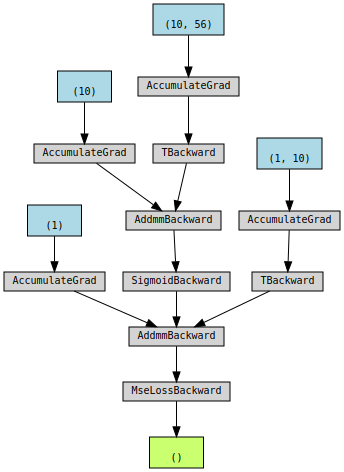

In [47]:
from torchviz import make_dot

make_dot(loss)

下面打印输出损失值。

**▶ 示例代码：**

```python
# 打印输出损失值
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')
```

**▶ 动手练习：**

Text(0, 0.5, 'MSE')

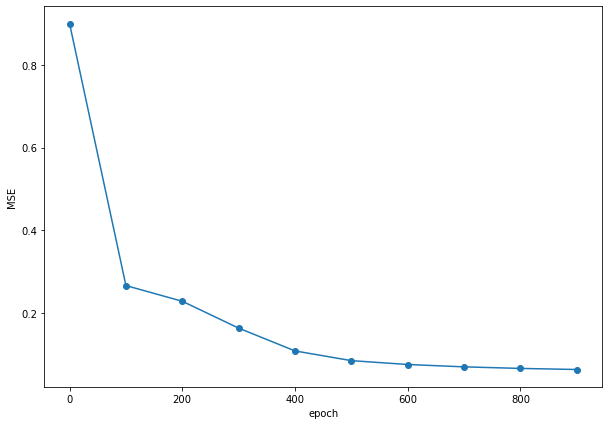

In [48]:
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(len(losses))*100, losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

在上段代码绘制出的图中，横坐标表示训练周期，纵坐标表示平均误差。

可以看到，平均误差快速地随训练周期而下降

<a href="#index">回到目录</a>

<h2 ><a id = "load">四、测试网络</a></h2>

### 4.1 使用测试数据集测试网络

接下来，我们便可以用训练好的神经网络在测试集上进行预测，并且将后21天的预测数据与真实数据画在一起做比较。

**▶ 示例代码：**

```python
# 用训练好的神经网络在测试集上进行预测
targets = test_targets['cnt'] #读取测试集的cnt数值
targets = targets.values.reshape([len(targets),1]) #将数据转换成合适的tensor形式
targets = targets.astype(float) #保证数据为实数

# 将属性和预测变量包裹在Variable型变量中
x = Variable(torch.FloatTensor(test_features.values))
y = Variable(torch.FloatTensor(targets))

# 用神经网络进行预测
predict = neu(x)
predict = predict.data.numpy()


# 将后21天的预测数据与真实数据画在一起并比较
# 横坐标轴是不同的日期，纵坐标轴是预测或者真实数据的值
fig, ax = plt.subplots(figsize = (10, 7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction', linestyle = '--')
ax.plot(targets * std + mean, label='Data', linestyle = '-')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
# 对横坐标轴进行标注
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)
```

**▶ 动手练习：**

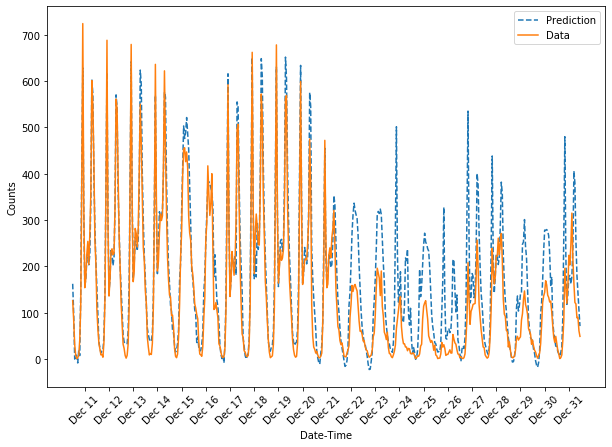

In [55]:
targets = test_targets['cnt']
targets = targets.values.reshape([len(targets),1])
targets = targets.astype(float)

x = torch.FloatTensor(test_features.values)
y = torch.FloatTensor(targets)

predict = neu(x)
predict = predict.data.numpy()

fig,ax = plt.subplots(figsize=(10,7))

mean, std = scaled_features['cnt']
ax.plot( predict * std + mean, label = 'Prediction', linestyle = '--' )
ax.plot( targets * std + mean,  label = 'Data', linestyle = '-' )
ax.legend()
ax.set_xlabel('Date-Time')
ax.set_ylabel('Counts')

dates = pd.to_datetime( rides['dteday'].loc[test_data.index])
dates = dates.apply( lambda d: d.strftime('%b %d'))

# np.arange( len(dates) )[12::24]
ax.set_xticks( np.arange( len(dates) )[12::24] )
_ = ax.set_xticklabels( dates[12::24], rotation=45)






### 4.2 预测结果分析

在上一步的代码绘制的图中，横坐标是不同的日期，纵坐标是预测或真实数据的值。

通过数据的可视化，我们可以观察到两个曲线基本是吻合的，但是在 12 月 25 日附近几天实际值和预测值偏差较大。为什么这段时间表现这么差呢？

仔细观察数据，我们知道 12 月 25 日正好是圣诞节。对于欧美国家来说，圣诞节就相当于是我们的春节，而从圣诞节之后的一周直到元旦都是假期。因此，在圣诞节的前后人们的出行习惯肯定会与往日有很大的不同。但是，在我们的训练样本中，因为整个数据仅仅有两年的长度，所以包含圣诞节前后的样本仅仅有一次，这就导致我们没办法对这一特殊假期的模式进行很好地预测。

<a href="#index">回到目录</a>

## 五、实验总结

至此，本实验结束，我们对本实验所经历的过程进行总结：

- 1.我们学习了使用神经网络模型解决实际问题的方法。
- 2.我们了解到对数据预处理的一些方法。
- 3.我们熟悉了搭建神经网络的一般流程。
- 4.我们了解到测试神经网络、简单分析神经网络的方法。

通过本次实验，我们才第一次接触到深度神经网络模型的真正应用，我们发现它真的可以在实际问题中取得很好的效果。

当然，现实中深度学习要解决的问题往往不像例子中那么简单，但是我们本系列的实验也刚刚开始，只要你有兴趣有毅力探索下去，还有什么问题是人类解决不了的哪？

<div style="color: #999;font-size: 12px;">©️ 本课程内容，由作者授权学堂在线发布，未经允许，禁止转载、下载及非法传播。</div>